In [21]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score


In [ ]:
## Import Data Set

In [10]:
import zipfile
import os

zip_file_path = "./dataset.zip"  
extract_to_path = "./dataset"   

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Dataset extracted to: {os.path.abspath(extract_to_path)}")


Dataset extracted to: E:\Projects\DL\dataset


In [ ]:
## Split and Preprocess the Dataset

In [165]:
import os
import shutil
from sklearn.model_selection import train_test_split

dataset_path = r"E:\Projects\DL\dataset\dataset\105_classes_pins_dataset"  
base_dir = r"E:\Projects\DL\processed_data" 
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")


os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


def extract_class_name(filepath):
    folder_name = os.path.basename(os.path.dirname(filepath))  
    return folder_name


def organize_dataset(dataset_path, train_dir, val_dir, test_dir, test_size=0.2, val_size=0.2):
    all_files = [] 

    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):  
                all_files.append(os.path.join(root, file))

    classes = {}

    
    for file in all_files:
        class_name = extract_class_name(file)
        if class_name not in classes:
            classes[class_name] = []
        classes[class_name].append(file)

    
    for class_name, files in classes.items():
        train, test = train_test_split(files, test_size=test_size, random_state=42)
        train, val = train_test_split(train, test_size=val_size, random_state=42)

        
        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        for file in train:
            try:
                shutil.copy(file, os.path.join(train_class_dir, os.path.basename(file)))
            except PermissionError as e:
                print(f"PermissionError copying {file}: {e}")

        for file in val:
            try:
                shutil.copy(file, os.path.join(val_class_dir, os.path.basename(file)))
            except PermissionError as e:
                print(f"PermissionError copying {file}: {e}")

        for file in test:
            try:
                shutil.copy(file, os.path.join(test_class_dir, os.path.basename(file)))
            except PermissionError as e:
                print(f"PermissionError copying {file}: {e}")

organize_dataset(dataset_path, train_dir, val_dir, test_dir)
print("Dataset organized successfully!")


Dataset organized successfully!


In [166]:
for split_dir, split_name in zip([train_dir, val_dir, test_dir], ["Train", "Validation", "Test"]):
    total_images = sum([len(files) for _, _, files in os.walk(split_dir)])
    print(f"{split_name} set: {total_images} images")

for class_name in os.listdir(train_dir): 
    print(f"Class: {class_name}, Train Images: {len(os.listdir(os.path.join(train_dir, class_name)))}")


Train set: 11139 images
Validation set: 2840 images
Test set: 3555 images
Class: Adriana Lima, Train Images: 136
Class: Alex Lawther, Train Images: 96
Class: Alexandra Daddario, Train Images: 144
Class: Alvaro Morte, Train Images: 88
Class: alycia dabnem carey, Train Images: 134
Class: Amanda Crew, Train Images: 74
Class: amber heard, Train Images: 139
Class: Andy Samberg, Train Images: 124
Class: Anne Hathaway, Train Images: 129
Class: Anthony Mackie, Train Images: 79
Class: Avril Lavigne, Train Images: 103
Class: barack obama, Train Images: 76
Class: barbara palvin, Train Images: 125
Class: Ben Affleck, Train Images: 80
Class: Bill Gates, Train Images: 77
Class: Bobby Morley, Train Images: 88
Class: Brenton Thwaites, Train Images: 133
Class: Brian J. Smith, Train Images: 64
Class: Brie Larson, Train Images: 108
Class: camila mendes, Train Images: 103
Class: Chris Evans, Train Images: 105
Class: Chris Hemsworth, Train Images: 101
Class: Chris Pratt, Train Images: 112
Class: Christian 

In [167]:
## Preprocess Images

In [168]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "./processed_data/train"
val_dir = "./processed_data/val"
test_dir = "./processed_data/test"

train_datagen = ImageDataGenerator(rescale=1./255,  
                                   rotation_range=20,  
                                   width_shift_range=0.2,  
                                   height_shift_range=0.2,  
                                   shear_range=0.2,  
                                   zoom_range=0.2,  
                                   horizontal_flip=True,  
                                   fill_mode="nearest")  

val_datagen = ImageDataGenerator(rescale=1./255) 

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  
    batch_size=32,
    class_mode="categorical"  
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)


Found 11139 images belonging to 105 classes.
Found 2840 images belonging to 105 classes.


In [169]:
## Visualize Data

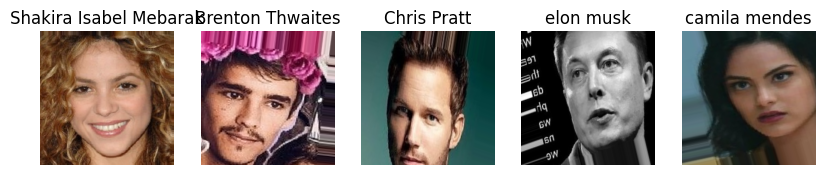

In [198]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    class_label = train_generator.class_indices
    class_label = list(class_label.keys())[np.argmax(labels[i])]
    plt.title(class_label)
    plt.axis('off')
plt.show()


In [ ]:
## IMPORT Libraries

In [179]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, MaxPooling2D
from tensorflow.keras.models import Model


In [ ]:
## Define a Bottleneck Block

In [180]:
def bottleneck_block(x, filters, stride=1):
    """
    A bottleneck residual block with three convolutional layers.
    Args:
        x: Input tensor.
        filters: Number of filters for the bottleneck block.
        stride: Stride for the first Conv layer (used for downsampling).
    Returns:
        Output tensor of the bottleneck block.
    """
    shortcut = x 


    x = Conv2D(filters, kernel_size=1, strides=stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)


    x = Conv2D(filters, kernel_size=3, strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)


    x = Conv2D(filters * 4, kernel_size=1, strides=1, padding="same")(x)
    x = BatchNormalization()(x)

    # Skip connection
    if stride != 1 or shortcut.shape[-1] != filters * 4:  
        shortcut = Conv2D(filters * 4, kernel_size=1, strides=stride, padding="same")(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut]) 
    x = Activation("relu")(x)  
    return x


In [181]:
## Define the ResNet-50 Architecture

In [182]:
def build_resnet50(input_shape, num_classes):

    inputs = Input(shape=input_shape)


    x = Conv2D(64, kernel_size=7, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding="same")(x)


    for _ in range(3):
        x = bottleneck_block(x, filters=64, stride=1)

    x = bottleneck_block(x, filters=128, stride=2)
    for _ in range(3):
        x = bottleneck_block(x, filters=128, stride=1)

    x = bottleneck_block(x, filters=256, stride=2)
    for _ in range(5):
        x = bottleneck_block(x, filters=256, stride=1)

    x = bottleneck_block(x, filters=512, stride=2)
    for _ in range(2):
        x = bottleneck_block(x, filters=512, stride=1)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    
    # Create Model
    model = Model(inputs, outputs)
    return model


## Compile and Train the Model

In [183]:
input_shape = (224, 224, 3) 
num_classes = 105  

resnet50_model = build_resnet50(input_shape, num_classes)

resnet50_model.compile(optimizer="adam",
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])

resnet50_model.summary()

history = resnet50_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    batch_size=32
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_53 (Conv2D)            │ (None, 112, 112, 64)      │           9,472 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_53        │ (None, 112, 112, 64)      │             256 │ conv2d_53[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_49 (Activation)    │ (None, 112, 112, 64)      │               0 │ batch_normalization_53[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 56, 56, 64)        │               0 │ activation_49[0][0]        │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_54 (Conv2D)            │ (None, 56, 56, 64)        │           4,160 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_54        │ (None, 56, 56, 64)        │             256 │ conv2d_54[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_50 (Activation)    │ (None, 56, 56, 64)        │               0 │ batch_normalization_54[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_55 (Conv2D)            │ (None, 56, 56, 64)        │          36,928 │ activation_50[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_55        │ (None, 56, 56, 64)        │             256 │ conv2d_55[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_51 (Activation)    │ (None, 56, 56, 64)        │               0 │ batch_normalization_55[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_56 (Conv2D)            │ (None, 56, 56, 256)       │          16,640 │ activation_51[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_57 (Conv2D)            │ (None, 56, 56, 256)       │          16,640 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_56        │ (None, 56, 56, 256)       │           1,024 │ conv2d_56[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_57        │ (None, 56, 56, 256)       │           1,02

 Total params: 23,802,857 (90.80 MB)

 Trainable params: 23,749,737 (90.60 MB)

 Non-trainable params: 53,120 (207.50 KB)

C:\Users\STW\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 1961s 5s/step - accuracy: 0.0159 - loss: 5.2893 - val_accuracy: 0.0155 - val_loss: 4.7994
Epoch 2/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 1923s 6s/step - accuracy: 0.0307 - loss: 4.5059 - val_accuracy: 0.0151 - val_loss: 6.3191
Epoch 3/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 1944s 6s/step - accuracy: 0.0359 - loss: 4.4144 - val_accuracy: 0.0144 - val_loss: 5.4185
Epoch 4/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 1850s 5s/step - accuracy: 0.0447 - loss: 4.3060 - val_accuracy: 0.0377 - val_loss: 4.7065
Epoch 5/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 1682s 5s/step - accuracy: 0.0623 - loss: 4.1384 - val_accuracy: 0.0180 - val_loss: 5.6515
Epoch 6/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 1682s 5s/step - accuracy: 0.0739 - loss: 3.9654 - val_accuracy: 0.0708 - val_loss: 4.0034
Epoch 7/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 1682s 5s/step - accuracy: 0.1030 - loss: 3.7513 - val_accuracy: 0.1239 - val_loss: 3.5759
Epoch 8/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 1751s 5s/step - accuracy: 0.1242 - loss: 3.5999 - 

## Train

## Evaluate the Model

In [186]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

test_dir = "./processed_data/test"  


test_data = image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),  
    batch_size=32,        
    label_mode="categorical"  
)


Found 3555 files belonging to 105 classes.


In [187]:
# Evaluate on the test dataset
test_loss, test_accuracy = resnet50_model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.2f}")


112/112 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.0128 - loss: 5110.9624
Test Accuracy: 0.01


In [ ]:
## Predictions

In [189]:
import numpy as np

y_pred_prob = resnet50_model.predict(test_data)  
y_pred = np.argmax(y_pred_prob, axis=1)  

y_true = np.concatenate([np.argmax(labels.numpy(), axis=1) for _, labels in test_data])


112/112 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step   


In [ ]:
## Evaluation Metrics

In [190]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

report = classification_report(y_true, y_pred, target_names=test_data.class_names)
print(report)

conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)


                        precision    recall  f1-score   support

          Adriana Lima       0.00      0.00      0.00        43
          Alex Lawther       0.00      0.00      0.00        31
    Alexandra Daddario       0.00      0.00      0.00        45
          Alvaro Morte       0.00      0.00      0.00        28
           Amanda Crew       0.00      0.00      0.00        24
          Andy Samberg       0.00      0.00      0.00        40
         Anne Hathaway       0.00      0.00      0.00        41
        Anthony Mackie       0.00      0.00      0.00        25
         Avril Lavigne       0.00      0.00      0.00        33
           Ben Affleck       0.00      0.00      0.00        26
            Bill Gates       0.01      0.08      0.02        25
          Bobby Morley       0.00      0.00      0.00        28
      Brenton Thwaites       0.00      0.00      0.00        42
        Brian J. Smith       0.00      0.00      0.00        21
           Brie Larson       0.00      

C:\Users\STW\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\STW\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\STW\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [ ]:
## Confusion Matrix

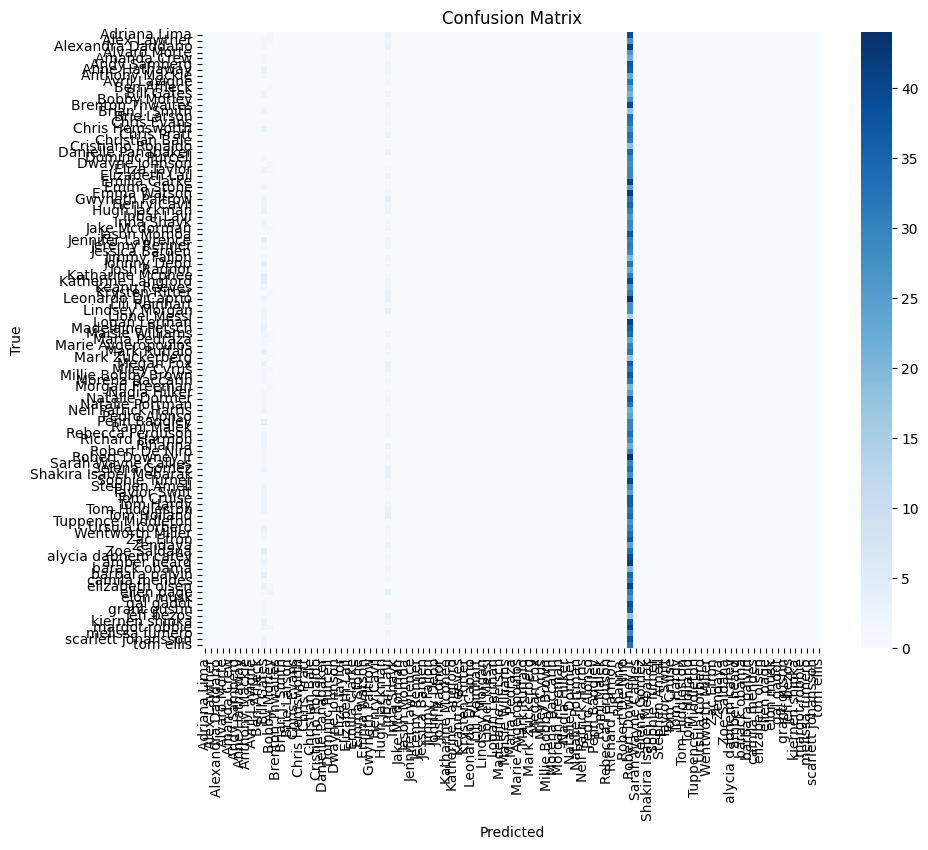

In [192]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=False, fmt="d", cmap="Blues", xticklabels=test_data.class_names, yticklabels=test_data.class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
## ROC-AUC Score

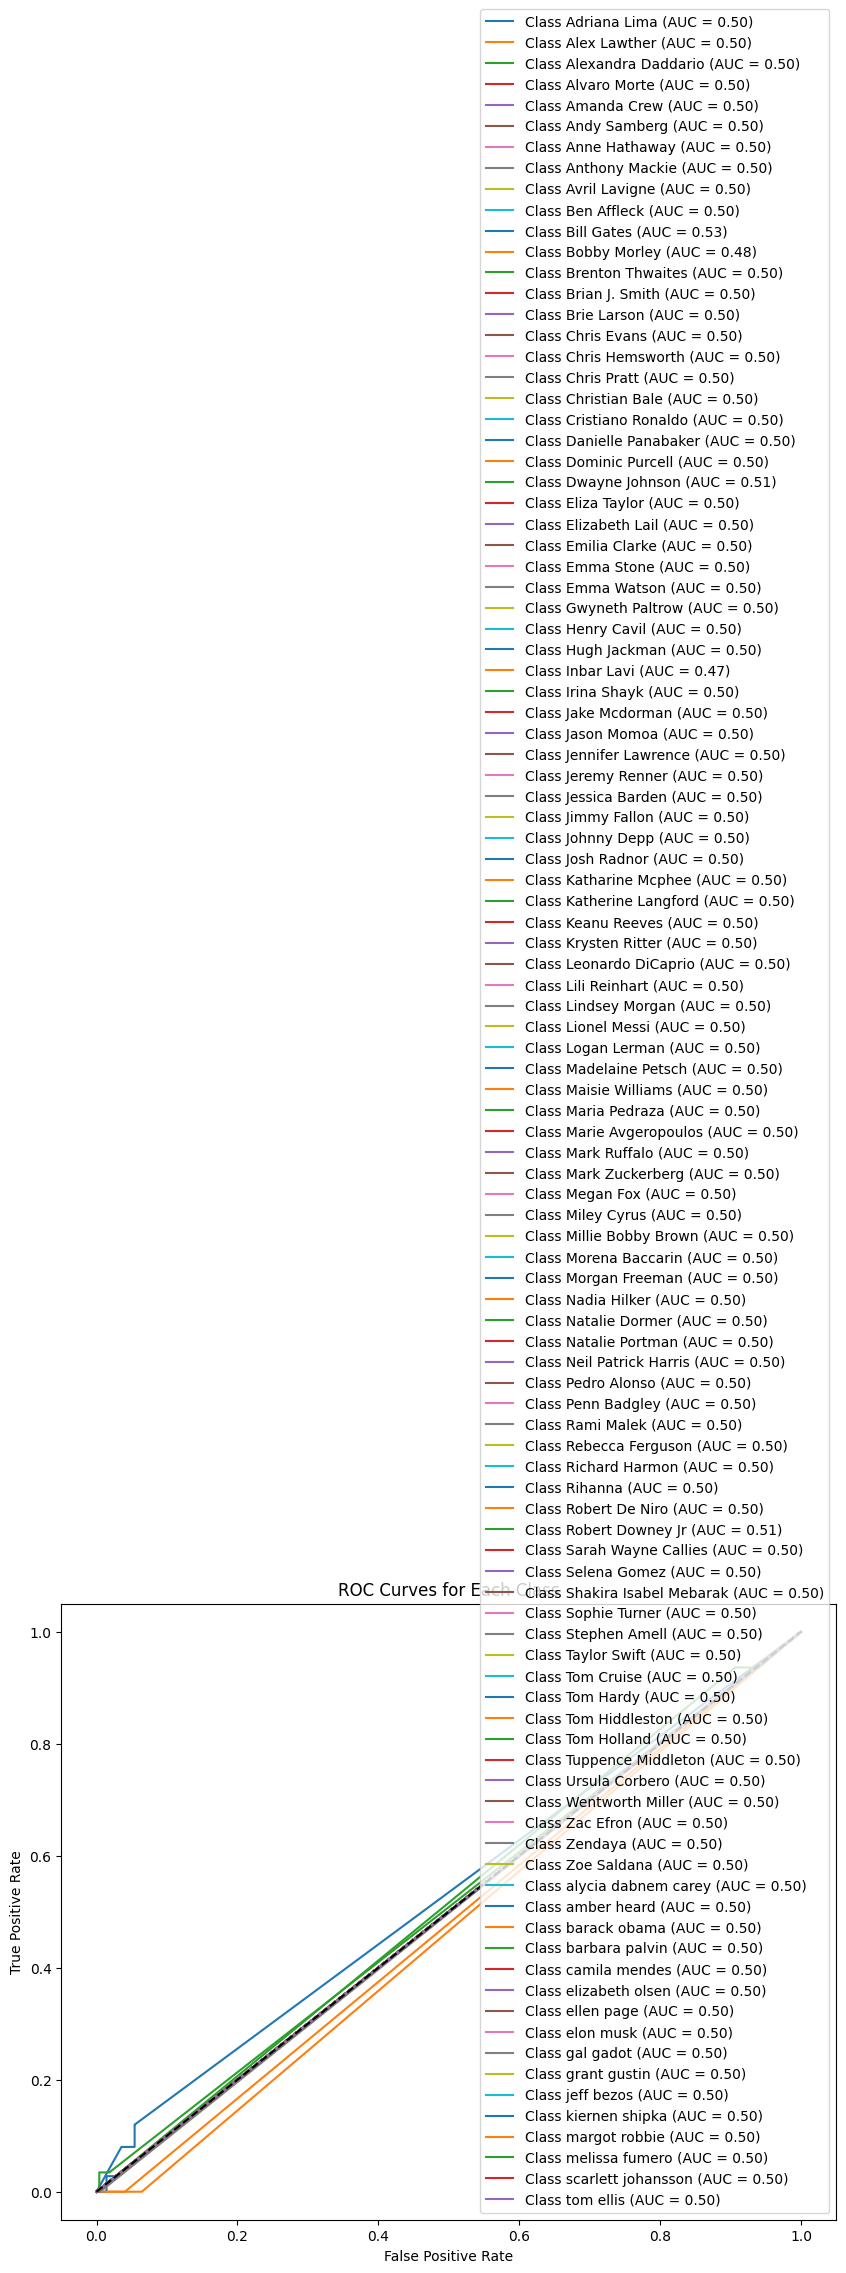

In [193]:
from sklearn.metrics import roc_curve, auc

fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(test_data.class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(test_data.class_names)):
    plt.plot(fpr[i], tpr[i], label=f"Class {test_data.class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curves for Each Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()
